## Project Overview

<p>In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.</p>

<p>In this project, I am going to use financial and email data of 146 Enron executives that are publicly availalbe to build a person of interest identifier. Person of interest(POI) is a person who commited fraud. I will use machine learning techniques to build an algorithm to identify POI.</p>

<p>There are four major steps in my project:</p>
<li>Enron Data Set Exploration</li>
<li>Feature Processing</li>
<li>Algorithm Choosing and Tuning</li> 
<li>Conclusion</li>

## Enron Data Set Exploration

In [1]:
#imports
%matplotlib inline
import pprint
import pickle
import sys
import matplotlib.pyplot as plt
from time import time
from operator import itemgetter
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support


sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

In [2]:
# Understanding the dataset and questions
data = pickle.load(open('final_project_dataset.pkl', 'rb'))

In [3]:
# How many people included in the dataset
len(data)

146

In [4]:
# What features and their values are included and the count
count = 0
for item in data:
    for feature in data[item]:
        count += 1
        print (feature, data[item][feature])
    print ("\n","Number of Features:", count)
    break

('salary', 365788)
('to_messages', 807)
('deferral_payments', 'NaN')
('total_payments', 1061827)
('exercised_stock_options', 'NaN')
('bonus', 600000)
('restricted_stock', 585062)
('shared_receipt_with_poi', 702)
('restricted_stock_deferred', 'NaN')
('total_stock_value', 585062)
('expenses', 94299)
('loan_advances', 'NaN')
('from_messages', 29)
('other', 1740)
('from_this_person_to_poi', 1)
('poi', False)
('director_fees', 'NaN')
('deferred_income', 'NaN')
('long_term_incentive', 'NaN')
('email_address', 'mark.metts@enron.com')
('from_poi_to_this_person', 38)
('\n', 'Number of Features:', 21)


In [5]:
# Checking for how many POIs are there in the dataset
count_poi = 0
for item in data:
    if data[item]['poi'] == 1:
        count_poi += 1
print (count_poi)

18


In the pdf document, there are 35 POIs, but there are only 18 POIs in the dataset. Only have 18 POIs may not provide enough examples to learn the patters. This is a potential problem.

In [6]:
# Count of nan values for each feature
nan_count = {}

for person in data:
    #nan_count[feature] = 0
    for feature in data[person]:
        if data[person][feature] == 'NaN':
            nan_count[feature] = nan_count.get(feature, 0) +1
print (nan_count)

# sorting nan_count dictionary by values

sorted(nan_count.items(), key=itemgetter(1))


{'salary': 51, 'to_messages': 60, 'deferral_payments': 107, 'total_payments': 21, 'long_term_incentive': 80, 'loan_advances': 142, 'bonus': 64, 'restricted_stock': 36, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'shared_receipt_with_poi': 60, 'from_poi_to_this_person': 60, 'exercised_stock_options': 44, 'from_messages': 60, 'other': 53, 'from_this_person_to_poi': 60, 'deferred_income': 97, 'expenses': 51, 'email_address': 35, 'director_fees': 129}


[('total_stock_value', 20),
 ('total_payments', 21),
 ('email_address', 35),
 ('restricted_stock', 36),
 ('exercised_stock_options', 44),
 ('salary', 51),
 ('expenses', 51),
 ('other', 53),
 ('to_messages', 60),
 ('shared_receipt_with_poi', 60),
 ('from_poi_to_this_person', 60),
 ('from_messages', 60),
 ('from_this_person_to_poi', 60),
 ('bonus', 64),
 ('long_term_incentive', 80),
 ('deferred_income', 97),
 ('deferral_payments', 107),
 ('restricted_stock_deferred', 128),
 ('director_fees', 129),
 ('loan_advances', 142)]

From the above dictionary we know that the features at the bottom have more NaN values, and may not be feasible to be part of 'feature_selection'.



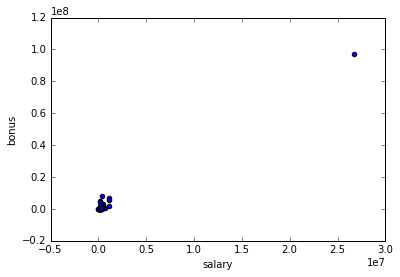

TOTAL {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


In [7]:
### read in data dictionary, convert to numpy array
#data_dict = pickle.load( open("../final_project/final_project_dataset.pkl", "r") )
#data_dict.pop('TOTAL')
features = ["salary", "bonus"]
data_dict = featureFormat(data, features)

for point in data_dict:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()
plt.figure(figsize=(20,10))

for k in data:
    if k == 'TOTAL':
        print k, data[k]

In [8]:
#Image(filename='data.png')

In [9]:
data.pop('TOTAL')  

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

From the above image and print out, we can see that'total' value is an outstanding outlier on the right upper conner. The salary and bonus of total is much larger than any other person. Remove total.

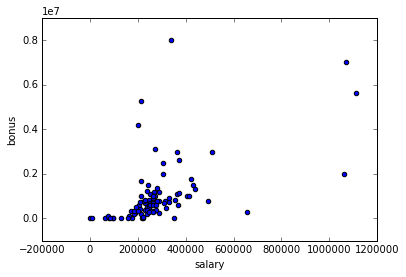

In [10]:
#features = ["salary", "bonus"]
data_dict = featureFormat(data, features)

for point in data_dict:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()
plt.figure(figsize=(30,10))


After removing total, we still see some outliers receive way more salaries and bonuses than others, 

In [11]:
# Identifying 3 people that receive highest salaries and 1 receive highest bonus.
salary = {}
bonus = {}
for person in data:
    if data[person]['salary'] == 'NaN':
        continue
    salary[person]=data[person]['salary']
    if data[person]['bonus'] == 'NaN':
        continue
    bonus[person]=data[person]['bonus']
    
salary_outliers = sorted(salary.items(), key=itemgetter(1), reverse=True)[:3]
bonus_outliers = sorted(bonus.items(), key=itemgetter(1), reverse=True)[:9]
print salary_outliers
print bonus_outliers



[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932)]
[('LAVORATO JOHN J', 8000000), ('LAY KENNETH L', 7000000), ('SKILLING JEFFREY K', 5600000), ('BELDEN TIMOTHY N', 5249999), ('ALLEN PHILLIP K', 4175000), ('KITCHEN LOUISE', 3100000), ('WHALLEY LAWRENCE G', 3000000), ('DELAINEY DAVID W', 3000000), ('MCMAHON JEFFREY', 2600000)]


All these people have salaries or bonuses more than seven digits. 'SKILLING JEFFREY K' and 'LAY KENNETH L' appear multiple times on the list. And they are important POIs. So these outliers we will keep in the dataset.

## Feature Processing

### Creating New Features

Now we are going to create new features from our feature list. There is 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', and 'to_messages'. Maybe POIs will send emails in between them pretty frequently. I would like to calculate 'from_poi_ratio' and 'to_poi_ratio', and test if they are good features.

In [12]:
for k in data:
    from_ratio = float(data[k]['from_poi_to_this_person'])/float(data[k]['from_messages'])
    to_ratio = float(data[k]['from_this_person_to_poi'])/float(data[k]['to_messages'])
    data[k]['from_poi_ratio'] = from_ratio
    data[k]['to_poi_ratio'] = to_ratio
    

In [13]:
features_list = []
for person in data:
    for feature in data[person]:
        features_list.append(feature)
    break
#print features_list
features_list.remove('email_address')
features_list.remove('poi')
features_list.insert(0, 'poi')
print features_list



['poi', 'to_messages', 'deferral_payments', 'expenses', 'deferred_income', 'long_term_incentive', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'to_poi_ratio', 'director_fees', 'bonus', 'total_stock_value', 'from_poi_to_this_person', 'from_this_person_to_poi', 'from_poi_ratio', 'restricted_stock', 'salary', 'total_payments', 'exercised_stock_options']


In [14]:
### Convert all float NaN on the newly created features to 0.0
myData = featureFormat(data, features_list, sort_keys=True)
labels, features = targetFeatureSplit(myData)

for i, row in enumerate(features):
    for j, x in enumerate(row):
        if str(x) == 'nan':
            features[i][j] = 0.0


### Feature Selection

In [15]:
# 1. SelectKBest 
skb = SelectKBest(f_classif, k = 5)
X_new = skb.fit(features, labels)

# Get Features Selected
features_selected=[features_list[i+1] for i in skb.get_support(indices=True)]
print 'The Features Selected by SKB:'
print features_selected

# 2. SelectKBest - GridSearchCV
skb = SelectKBest(f_classif)

pipeline =  Pipeline(steps=[("SKB", skb), ("GaussianNB", GaussianNB())])
params_skb = {'SKB__k': [5,10,15,20] }
          
gs = GridSearchCV(pipeline, param_grid = params_skb, scoring = 'f1')
XX_new = gs.fit(features, labels)

# Get Features Selected
features_selected=[features_list[i+1] for i in gs.best_estimator_.named_steps['SKB'].get_support(indices=True)]
print "\n", 'The Features Selected by SKB - GS:'
print features_selected

best_clf = gs.best_estimator_
print "\n", best_clf



The Features Selected by SKB:
['deferred_income', 'bonus', 'total_stock_value', 'salary', 'exercised_stock_options']

The Features Selected by SKB - GS:
['deferred_income', 'long_term_incentive', 'shared_receipt_with_poi', 'loan_advances', 'bonus', 'total_stock_value', 'restricted_stock', 'salary', 'total_payments', 'exercised_stock_options']

Pipeline(steps=[('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x10bab8c08>)), ('GaussianNB', GaussianNB())])


/Users/mbai/Applications/Anaconda/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Analysis of Feature Selection Using SelectKBest
<p>I tried SelectKBest to do feature selection independently and together with naivebayes classifier. The features that they selected are the same, which proved selectKBest does selection independently from classifiers.

<p> In addition, together using GridSearchCV and Pipeline, I was trying to find what K is optimal in terms of best f1 score. It turns out choosing 10 features is the winner from the best_estimator attribute. Thus, these ten features will be used in feature selection.

<p> Meanwhile, I used entire dataset instead of splitting up train and test datasets. My final performance might be biased since the test dataset has already been used in the process.

## Algorithm Choosing and Tuning

In [21]:
### split data into training and testing datasets under cross validation - StratifiedShuffleSplit
features_selected.insert(0, 'poi')
myData = featureFormat(data, features_selected, sort_keys=True)
labels, features = targetFeatureSplit(myData)

for i, row in enumerate(features):
    for j, x in enumerate(row):
        if str(x) == 'nan':
            features[i][j] = 0.0


cv = StratifiedShuffleSplit(labels, n_iter = 50, random_state = 42)
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

Note that if you use the entire dataset for feature selection, your final model performance is going to be biased since test data was already used in this process. The alternative to this, and more formal solution, is to combine feature selection with cross validation, so your final features are selected as a result of a cross validation process. For example, instead of using SelectKBest for feature selection, you can calculate the averaged feature F-scores over all folds of the cross validation and use the distribution of these average scores to choose an appropriate K. For this project it is fine to use the entire dataset, but acknowledgement of the negative impact should be demonstrated in the written response.

In [22]:
# Using feature_importances_ attributes to 

#features_list = ['deferred_income', 'bonus', 'total_stock_value', 'salary', 'exercised_stock_options']

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)


print accuracy_score(labels_test, pred)
print precision_score(labels_test, pred)
print recall_score(labels_test, pred)
print f1_score(labels_test, pred)


0.933333333333
1.0
0.5
0.666666666667


Using the default parameter of Naive Bayes Classifier gets not too bad results. The accuracy score is 0.93, precision score 1.0, recall score 0.5, and f1 score 0.67. As the next step, I'll use pipeline and gridsearch to try out different parameters in different algorithm. In this case. recall/precision or f1 should be used as the score to evaluate the performance.

In [35]:
# DecisionTreeClassifier()
dtree =  DecisionTreeClassifier()
scaler = MinMaxScaler()
param_grid = {"dt__criterion": ["gini", "entropy"],
              "dt__min_samples_split": [2, 10, 20],
              "dt__max_depth": [None, 2, 5, 10],
              "dt__min_samples_leaf": [1, 5, 10],
              "dt__max_leaf_nodes": [None, 5, 10, 20],
              }

gs =  Pipeline(steps=[('scaling',scaler), ("dt", dtree)])

dtcclf = GridSearchCV(gs, param_grid, scoring='f1', cv=cv)

dtcclf.fit(features, labels)

clf = dtcclf.best_estimator_
score = dtcclf.best_score_


print clf
print score

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.314142857143


In [36]:
svr = SVC()
clf_params= {
                       'clf__C': [1e-5, 1e-2, 1e-1, 1, 10, 1e2, 1e5],
                       'clf__gamma': [0.0],
                       'clf__kernel': ['linear', 'poly', 'rbf'],
                       'clf__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],  
                       'clf__class_weight': [{True: 12, False: 1},
                                                 {True: 10, False: 1},
                                               {True: 8, False: 1},
                                               {True: 15, False: 1},
                                               {True: 4, False: 1}]
                      }

#For this Pipeline:
pipe = Pipeline(steps=[('minmaxer', MinMaxScaler()), ('clf', SVC())])
a_grid_search = GridSearchCV(pipe, param_grid = clf_params,cv = cv, scoring = 'f1')
a_grid_search.fit(features,labels)

# pick a winner
best_clf = a_grid_search.best_estimator_
best_score = a_grid_search.best_score_
print best_clf
print best_score

Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=1, cache_size=200, class_weight={False: 1, True: 10}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.1, verbose=False))])
0.386791652792


## Conclusion

After trying out NaiveBayes, SVM, DecisionTree combined with Pipeline and GridSearchCV, NaiveBayes has the highest f1 score. SVM was too slow to be executed, thus may not be feasible for the datasets. The f1 score for the naive bayes is 0.67. 

<b>Importance about paramter tuning</b>
<p>Modification of parameters in machine learning algorithms can influence the outcome of the learning process. The goal of algorithm tuning is to find the best point or points for the problem, and to optimize against the test harness.So spending the time to build a trusted algorithm is very important to the problem.</p>

<b>Importance of Validation</b>
<p>Cross validation involves splitting data into train and test datasets, performing the analysis on the training set and validating the analysis on the test set. To reduce variability, multiple rounds of cross validation are performed using different partitions, and the validation results are averaged over the rounds.</p>
<p>In this dataset, since there are only a few POI included in the dasaset, using StratifiedShuffleSplit will make sure that each training and testing datasets have POI labels in it. StratifiedShuffleSplit object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

<b> Recall, Precision and F1 </b>
<p>High recall but low precision rate means, nearly every time a POI shows up in the test set, it's easy to identify them. The cost of this is some false positives, wher non-POIs get flagged. </p>

<p>On the other hand, high precision but low recall rate means whenever a POI gets flagged in the test set, it's very likely to be a real POI and not a false alarm. But the price of it is missing real POIs.<p>

<p>F1 Score is a weighted average of recall and precision score, which is used to evaluate the performance of the algorithms here.</p>



